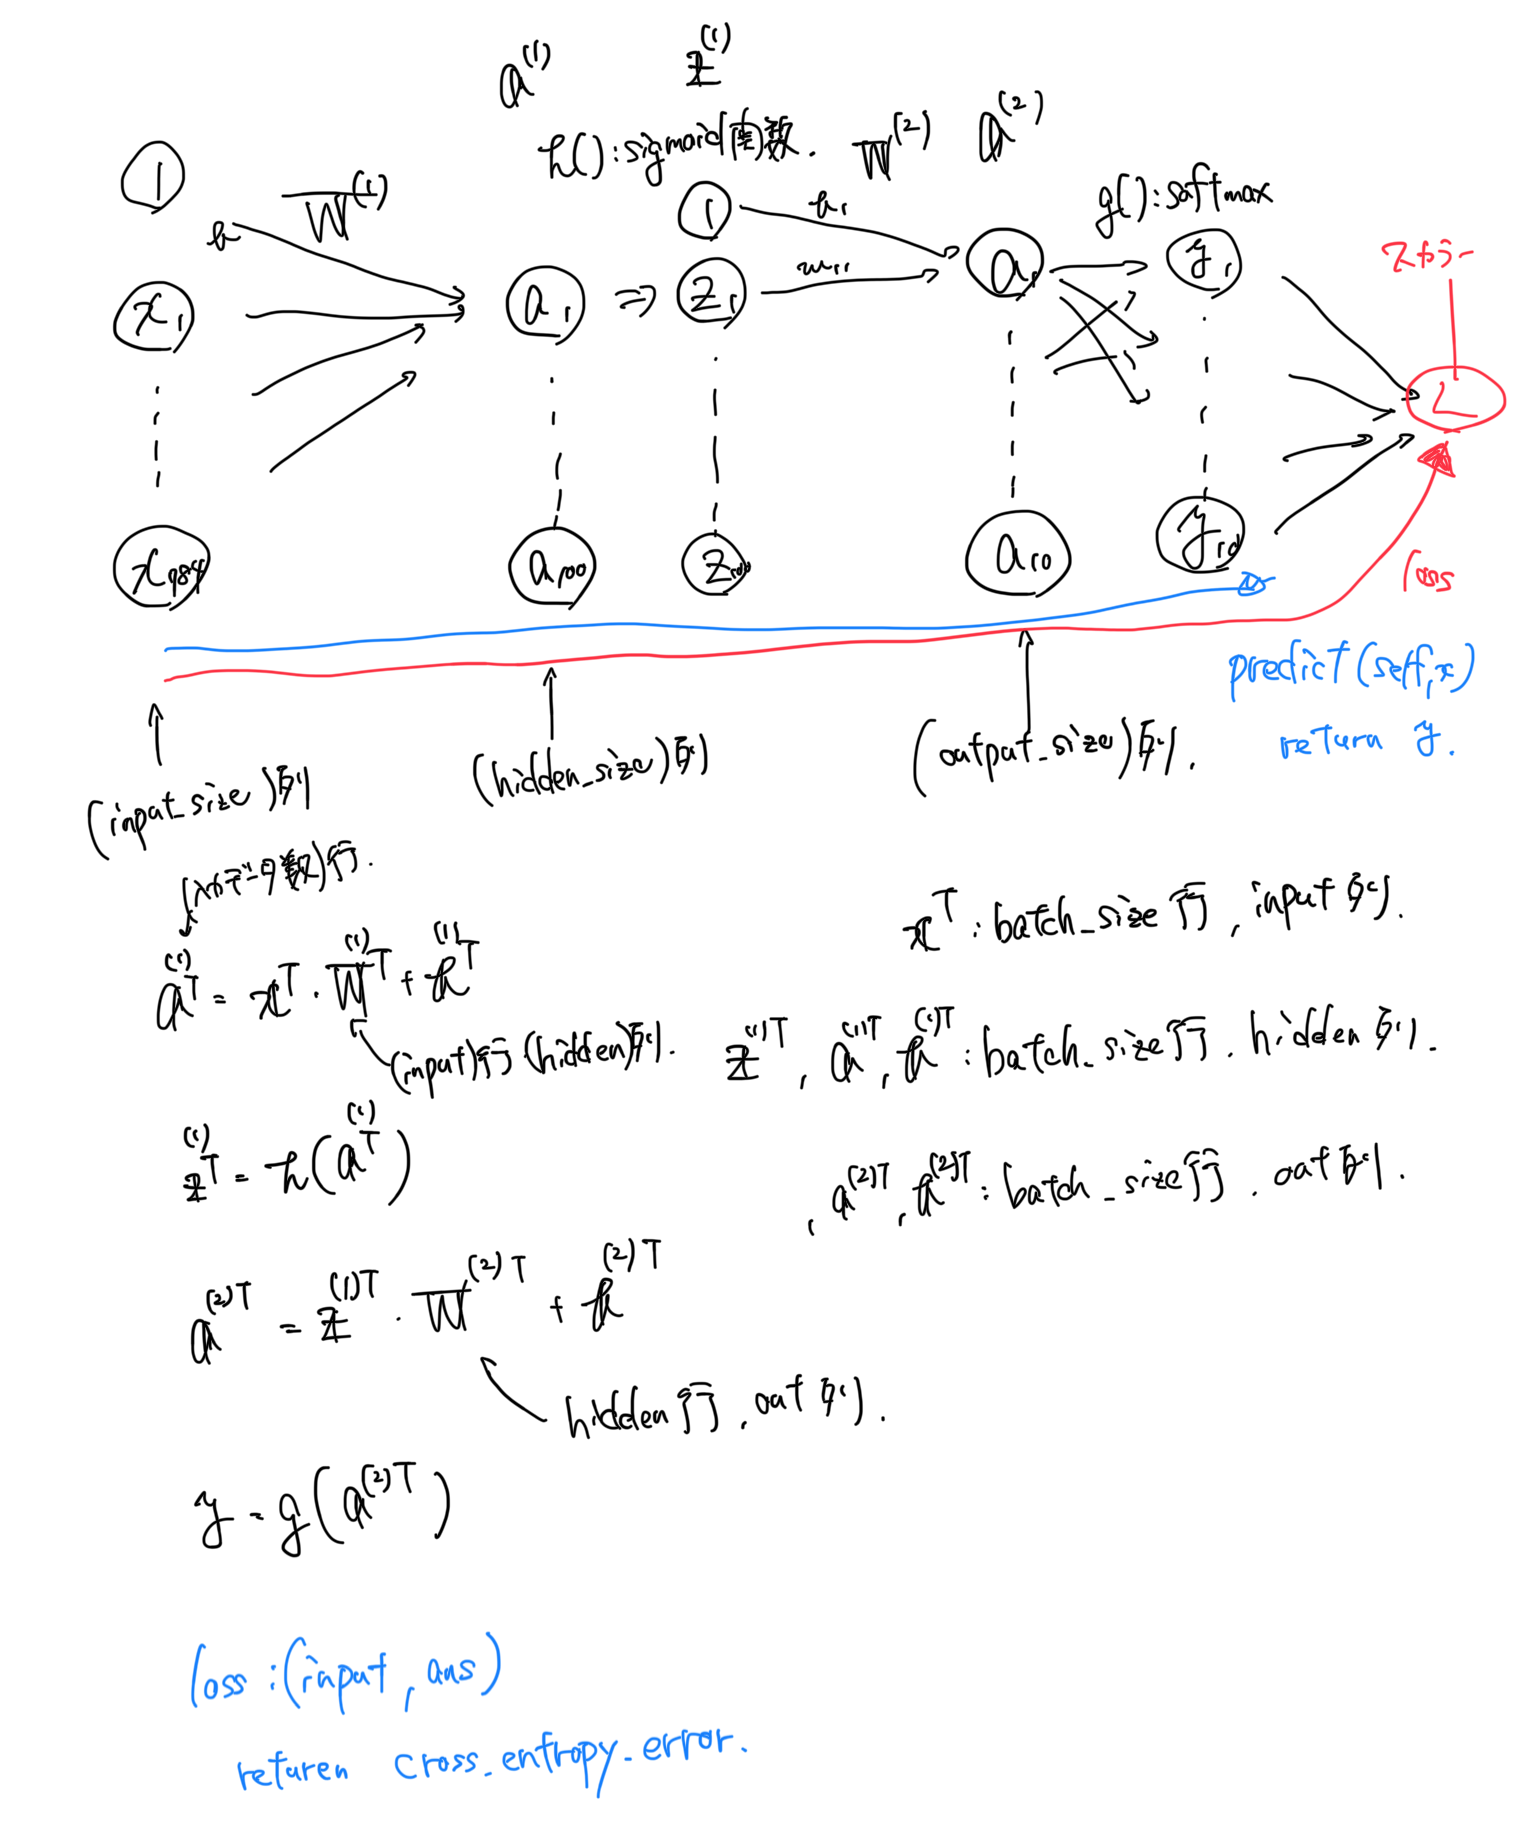

In [25]:
import pickle #mnistデータセット読み出し用
import numpy as np
from numpy.random import *
from collections import OrderedDict

#MNISTデータセットを読み込む為の関数
def get_mnist_data():
    with open('/Users/takuya.teramoto/Documents/dataset/processed_mnist.pkl', 'rb') as f:
        dataset = pickle.load(f)
    return dataset['train_img'], dataset['train_label'], dataset['test_img'], dataset['test_label']

#ソフトマックス関数。xはarray。返り値も同じ形のarray。
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

#シグモイド関数。xはarray。返り値も同じ形のarray。
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#ミニバッチに対応した交差エントロピー誤差を計算する関数（出力は平均値)
#pred, ansはそれぞれ学習後の予測値と正解ラベル
#入力はarray。行方向がサンプル数（バッチ数)に対応している。
def cross_entropy_error(pred, ans):
    #1次元配列の場合は1行n列の2次元に変換する
    if pred.ndim ==1:
        pred = pred.reshape(1, pred.size)
        ans = pred.reshape(1, ans.size)
    #行数を取得（行数＝データサイズ＝バッチサイズ） 
    batch_size = pred.shape[0]
    return -np.sum(ans * np.log(pred + 1e-7)) / batch_size

#入力した関数の勾配を求める（関数をベクトルで偏微分）。f:関数, x:ベクトル(array)
def num_grad(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx].copy()
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [26]:
#各layerの定義
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        #x<=0を満たす箇所を0にする
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout #dx=1*dout

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [27]:
#2層ニューラルネットワーククラスの実装
class TwoLayerNet:
    #input_size: 入力層ニューロンの数
    #hidden_size: 隠れ層ニューロンの数
    #output_size: 出力層ニューロンの数
    #weight_init_std: 重みの初期値の標準偏差にかける係数
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        #バイアスは無しで計算（仮）
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
        
        #レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer= SoftmaxWithLoss()
        
    #入力値から重みとバイアスを用いて予想結果を算出する関数
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x

    #入力値と正解ラベル（教師データ）から損失を計算する関数
    def loss(self, input_x, ans):
        pred = self.predict(input_x)
        loss = self.lastLayer.forward(pred, ans)
        
        return loss
    
    #入力値と正解ラベル（教師データ）から正解率を算出する関数
    def accuracy(self, input_x, ans):
        pred = self.predict(input_x)
        pred_idx = np.argmax(pred, axis=1)
        ans_idx = np.argmax(ans, axis=1)
        #accuracyはfloat型で計算する
        accuracy = np.sum(pred_idx == ans_idx) / float(input_x.shape[0])
        
        return accuracy
    
    #順伝播で勾配を計算する関数
    def forward_grad(self, input_x, ans):
        #損失関数をlambdaで記述
        loss_W = lambda W: self.loss(input_x, ans)
        
        #勾配ベクトルを定義
        forward_grads = {}
        
        #各パラメータに対して勾配を算出する
        for key in ('W1', 'b1', 'W2', 'b2',):
            forward_grads[key] = num_grad(loss_W, self.params[key])
        
        return forward_grads
    
    def backward_grad(self, input_x, ans):
        # forward処理を走らせ損失を求め、インスタンス変数を更新する。
        self.loss(input_x, ans)
        
        #backward処理を走らせることで、layerに定義したように、各layerの勾配のインスタンス変数を更新する。
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        #layersを逆向きにソートし順番に
        #OrderedDictをlistに変換
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
        
        #重みパラメータとして、各layerの勾配のインスタンス変数を返す
        backward_grads = {}
        backward_grads['W1'] = self.layers['Affine1'].dW
        backward_grads['b1'] = self.layers['Affine1'].db
        backward_grads['W2'] = self.layers['Affine2'].dW
        backward_grads['b2'] = self.layers['Affine2'].db
        
        return backward_grads


# SGD
$$ \boldsymbol{W} \leftarrow \boldsymbol{W} - \eta \frac{\partial L}{\partial \boldsymbol{W}} $$

# Momentum
$$ \boldsymbol{v} \leftarrow \alpha \boldsymbol{v} - \eta \frac{\partial L}{\partial \boldsymbol{W}} $$
$$ \boldsymbol{W} \leftarrow \boldsymbol{W} + \boldsymbol{v} $$

# AdaGrad
$$ \boldsymbol{h} \leftarrow \boldsymbol{h} + \frac{\partial L}{\partial \boldsymbol{W}} \odot \frac{\partial L}{\partial \boldsymbol{W}} $$
$$ \boldsymbol{W} \leftarrow \boldsymbol{W} - \eta \frac{1}{\sqrt{\boldsymbol{h}}} \frac{\partial L}{\partial \boldsymbol{W}} $$

# Adam
$$ m_i^t \leftarrow \beta_1 m_i^{t-1}  + (1-\beta_1)\frac{\partial L}{\partial w_i^t}$$
$$ v_i^t \leftarrow \beta_2 v_i^{t-1} + (1-\beta_2) \Bigl( \frac{\partial L}{\partial w_i^t} \Bigr)^2 $$
$$ m_i^t \leftarrow \frac{m_i^t}{1 - \beta_1^t} $$
$$ v_i^t \leftarrow \frac{v_i^t}{1 - \beta_2^t} $$
$$ w_i^{t+1} \leftarrow w_i^t - \frac{\eta}{\sqrt{v_i^t} + \epsilon}m_i^t $$


# 補足
$$ \nabla L( \boldsymbol{\beta} ) = \frac{\partial}{\partial \boldsymbol{\beta}} L ( \boldsymbol{\beta} ) $$

In [28]:
#optimizerの定義
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -=self.lr * grads[key]
            
class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# ミニバッチ学習の実装

In [29]:
#学習データの読み込み
train_img, train_label, test_img, test_label = get_mnist_data()

#損失の値を格納するリスト
train_loss_list = []
train_acc_list = []
test_acc_list = []

#ハイパーパラメーターhyperparameterの設定

iteration_num = 10000
train_size = train_img.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

#optimizerの選択
optimizer = Adam()

net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [30]:
#順伝播と逆伝播の計算が大きくずれていないことを確認する
# train_img_batch = train_img[:3]
# train_label_batch = train_label[:3]
# num_grad = net.forward_grad(train_img_batch, train_label_batch)
# backprop_grad = net.backward_grad(train_img_batch, train_label_batch)

In [31]:
# for key in num_grad.keys():
#     diff = np.average(np.abs(backprop_grad[key] - num_grad[key]))
#     print(key + ':' + str(diff))

In [32]:
#iterationの回数学習する
for i in range(iteration_num):
    #ミニバッチの取得、戻り値はarray
    batch_mask = np.random.choice(train_size, batch_size)
    train_img_batch = train_img[batch_mask]
    train_label_batch = train_label[batch_mask]
    
    #勾配の計算
    grads = net.backward_grad(train_img_batch, train_label_batch)
    
    #パラメータの更新
    optimizer.update(net.params, grads)
    
    #学習経過の記録
    loss = net.loss(train_img_batch, train_label_batch)
    train_loss_list.append(loss)
    
    #1epochごとにtrain, testデータそれぞれの正解率を算出し、リストに収納する
    if i % iter_per_epoch == 0:
        train_acc = net.accuracy(train_img, train_label)
        test_acc = net.accuracy(test_img, test_label)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

In [33]:
test_acc_list[-1]

0.9751

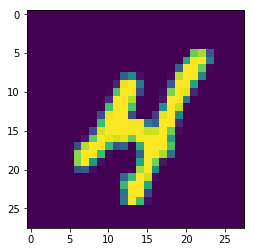

answer: 4
predict: 4


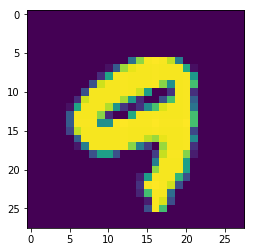

answer: 9
predict: 9


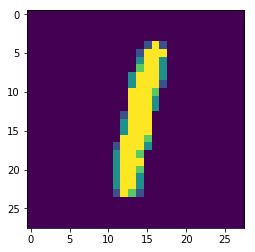

answer: 1
predict: 1


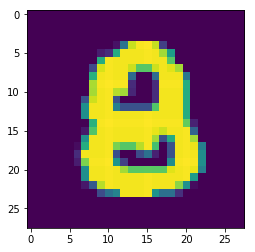

answer: 8
predict: 8


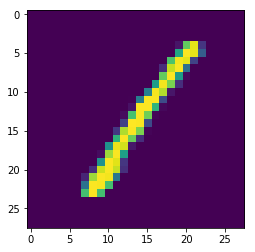

answer: 1
predict: 1


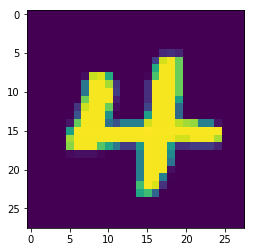

answer: 4
predict: 4


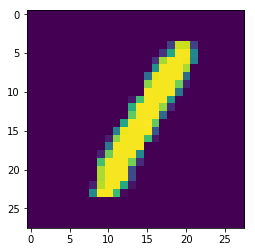

answer: 1
predict: 1


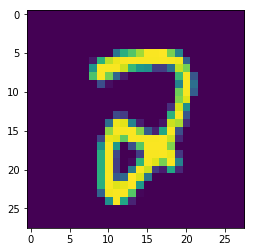

answer: 2
predict: 2


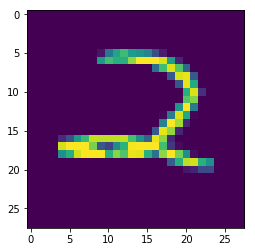

answer: 2
predict: 2


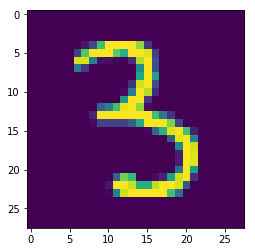

answer: 3
predict: 3


In [34]:
import matplotlib.pylab as plt

labels = np.random.randint(0, train_img.shape[0], (10, ))

for label in labels:
    sample_train_img = train_img[label]
    pred = net.predict(sample_train_img.reshape(1, -1))
    plt.imshow(sample_train_img.reshape((28, 28)))
    plt.show()
    print("answer: {}".format(train_label[label].argmax()))
    print("predict: {}".format(pred[0].argmax()))

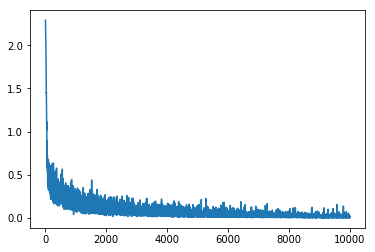

In [35]:
plt.plot(train_loss_list)